In [1]:
import numpy as np
import numba
import matplotlib.pyplot as plt
import os
import time
import math

from numpy import exp, sum
from scipy.optimize import differential_evolution

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [2]:
if not os.path.exists('./plots/ExcessOfLoss'): os.makedirs('./plots/ExcessOfLoss')

In [102]:
end = 20
DELTA = 0.02
n = int(end/DELTA)

beta1 = 8.0
beta2 = 4.0
beta3 = 5.0

lambda1 = 0.5
lambda2 = 3.0
lambda3 = 2.0
beta = beta1 + beta2 + beta3

p11 = 1.0
p12 = 0.06
p13 = 0.05

p21 = 0.03
p22 = 1.0
p23 = 0.01

p31 = 0.007
p32 = 0.005
p33 = 1.0

eta1 = 0.35
eta = 0.3
c=0.3

d = np.array((n+1)*[0.0])
dhat = np.array(n*[0.0])
dhat0 = np.array(n*[0.0])
d1 = np.array((n+1)*[0.0])
dhat1 = np.array(n*[0.0])
d[0] = 1.0
d1[0] = 1.0
B1 = np.array(n*[0.0])
B2 = np.array(n*[0.0])
B3 = np.array(n*[0.0]) 

In [103]:
NAME = '-EOL-'+str(lambda1)+'-'+str(lambda2)+'-'+str(lambda3)+'-'+str(beta1)+ '-' + str(beta2) +'-'+ str(beta3)+'-'+str(p11)+'-' +str(p12)+'-'+str(p13)+'-'+str(p21)+'-'+str(p22)+'-'+str(p23)+ '-'+str(p31)+ '-'+str(p32)+ '-'+str(p33)+ '-'+str(eta1)+ '-'+str(eta) + '.pdf'

In [104]:
def H(x): return (x>=0)*1
H = numba.autojit(H, nopython=True)

In [105]:
def FR1(a1,lambda1,x):
    return exp(-lambda1*x)*(H(x-a1)-1)+1

def FR12(a1,a2,lambda1,lambda2,x):
    return (-lambda2*(H(x-a1-a2)-H(x-a1))*exp(lambda2*(-x+a1)-lambda1*a1)+lambda1*(H(x-a1-a2)-H(x-a2))*exp(lambda1*(-x+a2)-lambda2*a2)+H(x-a2)*exp(-lambda2*x)*lambda1-H(x-a1)*exp(-lambda1*x)*lambda2 - exp(-lambda2*x)*lambda1 + exp(-lambda1*x)* lambda2 + lambda1-lambda2)/(lambda1-lambda2)

def FR123(a1,a2,a3,x):
    return (-lambda3**2*(lambda1-lambda2)*(H(x-a1-a2)-H(x-a1-a2-a3))*exp(lambda3*(-x+a1+a2)-lambda1*a1-lambda2*a2) + lambda2**2*(lambda1-lambda3)*(H(x-a1-a3)-H(x-a1-a2-a3))*exp(lambda2*(-x+a1+a3)-lambda1*a1-lambda3*a3) - lambda1**2*(lambda2-lambda3)*(H(x-a2-a3)-H(x-a1-a2-a3))*exp(lambda1*(-x+a2+a3)-lambda2*a2-lambda3*a3) + lambda2*lambda3*(lambda1-lambda3)*(H(x-a1-a2)-H(x-a1))*exp(lambda2*(-x+a1) - lambda1*a1)-lambda2*lambda3*(lambda1-lambda2)*(H(x-a1-a3)-H(x-a1))*exp((-x+a1)*lambda3-lambda1*a1)-lambda1*lambda3*(lambda2-lambda3)*(H(x-a1-a2)-H(x-a2))*exp(lambda1*(-x+a2)-lambda2*a2) - lambda1*lambda3*(lambda1-lambda2)*(H(x-a2-a3)-H(x-a2))*exp((-x+a2)*lambda3-lambda2*a2)+lambda1*lambda2*(lambda2-lambda3)*(H(x-a3)-H(x-a1-a3))*exp((-x+a3)*lambda1-lambda3*a3)-lambda1*lambda2*(lambda1-lambda3)*(H(x-a3)-H(x-a2-a3))*exp((-x+a3)*lambda2-lambda3*a3)  +exp(-lambda1*x)*lambda2*lambda3*(lambda2-lambda3)*H(x-a1) - exp(-lambda2*x)* lambda1*lambda3*(lambda1-lambda3)*H(x-a2) + exp(-lambda3*x)*lambda1*lambda2*(lambda1-lambda2)*H(x-a3) - exp(-lambda1*x)* lambda2*lambda3*(lambda2-lambda3)+exp(-lambda2*x)*lambda1*lambda3*(lambda1-lambda3) - (exp(-lambda3*x)*lambda1*lambda2-(lambda1-lambda3)*(lambda2-lambda3))*(lambda1-lambda2))/((lambda1-lambda2)*(lambda1-lambda3)*(lambda2-lambda3))


def ER123(a1,a2,a3):
    return 1/lambda3+1/lambda2+1/lambda1-1/(exp(lambda3*a3)*lambda3)-1/(exp(lambda2*a2)*lambda2)-1/(exp(lambda1*a1)*lambda1)

In [106]:
FR1   = numba.autojit(FR1  , nopython=True)
FR12  = numba.autojit(FR12 , nopython=True)
FR123 = numba.autojit(FR123, nopython=True)
ER123 = numba.autojit(ER123, nopython=True)

In [107]:
def GR(a1, a2, a3, x):
    return H(x)*((beta1*(1-p12)*(1-p13)*FR1(a1,lambda1, x) + beta2*(1-p21)*(1-p23)*FR1(a2,lambda2, x) + beta3*(1-p31)*(1-p32)*FR1(a3,lambda3, x) + (beta1*p12*(1-p13) + beta2*p21*(1-p23))*FR12(a1, a2,lambda1,lambda2, x) + (beta1*p13*(1-p12) + beta3*p31*(1-p32))*FR12(a1, a3,lambda1,lambda3, x) + (beta2*p23*(1-p21)+beta3*p32*(1-p31))*FR12(a2, a3,lambda2,lambda3, x) + (beta1*p11*p12*p13 + beta2*p21*p22*p23 + beta3*p31*p32*p33)*FR123(a1, a2, a3, x))/beta)


def EG(a1, a2, a3):
    return (beta1*(1-p12)*(1-p13)*ER123(a1,0,0) + beta2*(1-p21)*(1-p23)*ER123(0,a2,0) + beta3*(1-p31)*(1-p32)*ER123(0,0,a3) + (beta1*p12*(1-p13) + beta2*p21*(1-p23))*ER123(a1, a2,0) + (beta1*p13*(1-p12) + beta3*p31*(1-p32))*ER123(a1,0, a3) + (beta2*p23*(1-p21)+beta3*p32*(1-p31))*ER123(0,a2, a3) + (beta1*p11*p12*p13 + beta2*p21*p22*p23 + beta3*p31*p32*p33)*ER123(a1, a2, a3))/beta

In [108]:
GR = numba.autojit(GR, nopython=True)
EG = numba.autojit(EG, nopython=True)

In [109]:
@numba.autojit(nopython = True) 
def DGR(a1, a2, a3, j):
    return GR(a1,a2,a3,j*DELTA)-GR(a1,a2,a3,(j-1)*DELTA)

In [110]:
E1 = EG(np.inf,np.inf,np.inf)
@numba.autojit(nopython = True) 
def pR(a1,a2,a3):
    return (1+eta)*beta*E1 - ((1+eta1)*beta*(E1-EG(a1,a2,a3)))

In [111]:
@numba.autojit(nopython = True) 
def DGR1(a, j):
    return DGR(a, a, a, j)

In [112]:
#E1 = EG(np.inf,np.inf,np.inf)
@numba.autojit(nopython = True) 
def pR1(a):
    return pR(a, a, a)

In [113]:
INF = 120.0
@numba.autojit(nopython = True) 
def Hinf(a,d,i):
    j1 = np.arange(i)
    j2 = np.arange(1, i+1)
    if a[0] < 0.0 : a[0]=0.0
  #  if a[1] < 0.0 : a[1]=0.0
   # if a[2] < 0.0 : a[2]=0.0
    a[0] = math.floor(a[0]/DELTA)*DELTA
    #a[1] = math.floor(a[1]/DELTA)*DELTA
    #a[2] = math.floor(a[2]/DELTA)*DELTA
    pRR = pR1(a[0])
    if pRR>0: return ((c+beta)*d[i]-0.5*beta*sum((d[i-j1]+d[i-j2])*DGR1(a[0], j2)))/pRR
    else : return  1000.0 

@numba.autojit(nopython = True) 
def Hinf1(a,d,i): return Hinf([INF,d,i])
@numba.autojit(nopython = True) 
def Hinf2(a,d,i): return Hinf([a[0],INF,a[1]],d,i)
@numba.autojit(nopython = True) 
def Hinf3(a,d,i): return Hinf([a[0],a[1],INF],d,i)

@numba.autojit(nopython = True) 
def Hinf12(a,d,i): return Hinf([INF,INF,a[0]],d,i)
@numba.autojit(nopython = True) 
def Hinf13(a,d,i): return Hinf([INF,a[0],INF],d,i)
@numba.autojit(nopython = True) 
def Hinf23(a,d,i): return Hinf([a[0],INF,INF],d,i)

In [114]:
L1=L2=L3=0.0001
U1=U2=U3=200.0

TIME=time.time()
for i in range(n):
    MIN   = differential_evolution(Hinf ,args=(d,i),  bounds= [(0.0001, 20)],tol=0.0001) 
   # MIN1  = differential_evolution(Hinf,args=(d,i),  bounds= [(20,30 )], tol=0.0001) 
   # MIN2  = differential_evolution(Hinf,args=(d,i),  bounds= [(60, 70)], tol=0.0001) 
   # MIN3  = differential_evolution(Hinf,args=(d,i),  bounds= [(120, 130)], tol=0.0001) 
   # MIN12 = differential_evolution(Hinf,args=(d,i), bounds= [(150, 170)],tol=0.0001) 
   # MIN13 = differential_evolution(Hinf13,args=(d,i), bounds= [(L2, U2)],tol=0.0001) 
   # MIN23 = differential_evolution(Hinf23,args=(d,i), bounds= [(L1, U1)],tol=0.0001) 
    
   # vals = np.array([MIN.fun,Hinf([INF],d,i)])
    #Ind = vals.argmin()
   # if Ind==0:
    B1[i] = MIN.x[0]
    #    B2[i] = MIN.x[1]
     #   B3[i] = MIN.x[2]
    #if Ind==1:
        #B1[i] = INF
        #B2[i] = MIN1.x[0]
       # B3[i] = MIN1.x[1]
    #if Ind==2:
     #   B1[i] = MIN2.x[0]
      #  B2[i] = INF
       # B3[i] = MIN2.x[1]
   # if Ind==3:
    #    B1[i] = MIN3.x[0]
      #  B2[i] = MIN3.x[1]
       # B3[i] = INF
    #if Ind==4:
     #   B1[i] = INF
      #  B2[i] = INF
     #   B1[i] = MIN12.x[0]
    #if Ind==5:
     #   B1[i] = INF
      #  B2[i] = MIN13.x[0]
       # B3[i] = INF
   # if Ind==6:
    #    B1[i] = MIN23.x[0]
     #   B2[i] = INF
      #  B3[i] = INF
    #if Ind==7:
     #   B1[i] = INF
       # B2[i] = INF
        #B3[i] = INF
        
    #dhat[i] = MIN.fun
    #d[i+1]=d[i]+DELTA*dhat[i]
    dhat[i] = MIN.fun
    d[i+1]=d[i]+DELTA*dhat[i]
   # if (B1[i] > 0.00001) & (B1[i]< INF) : 
    #    L1 = np.maximum(0,B1[i] - 0.1)
     #   U1 = L1 + 0.4
    #else :
     #   L1 = 80
      #  U1 = 90
  #  if (B2[i] > 0.00001) & (B2[i]< INF) : 
  #      L2 = np.maximum(0,B2[i] - 0.1)
    #    U2 = L2+0.2
   # if (B3[i] > 0.00001) & (B3[i]< INF) : 
    #    L3 = np.maximum(0,B3[i] - 0.1)
     #   U3 = L3+0.2

    if (i+1)%(n//20)==0: 
        print(str(round(100*(i+1)/n))+'%, ' + 'd('+str(round((i+1)*DELTA,2))+') = '+
                           str(d[i+1]) + ', time = '+str(round(time.time()-TIME,1))+' seconds')

5%, d(1.0) = 1.5045770300243861, time = 18.1 seconds
10%, d(2.0) = 1.8894216629234948, time = 20.1 seconds
15%, d(3.0) = 2.212931802767048, time = 23.5 seconds
20%, d(4.0) = 2.4980671283610945, time = 27.3 seconds
25%, d(5.0) = 2.758789183576318, time = 30.3 seconds
30%, d(6.0) = 3.003116480348641, time = 33.7 seconds
35%, d(7.0) = 3.2363230671194017, time = 37.3 seconds
40%, d(8.0) = 3.462061130412173, time = 41.0 seconds
45%, d(9.0) = 3.683021099952985, time = 44.8 seconds
50%, d(10.0) = 3.901301077737808, time = 48.8 seconds
55%, d(11.0) = 4.1186121548949775, time = 52.9 seconds
60%, d(12.0) = 4.336401608057243, time = 57.3 seconds
65%, d(13.0) = 4.555927355199744, time = 62.1 seconds
70%, d(14.0) = 4.778305567350853, time = 66.6 seconds
75%, d(15.0) = 5.004541472131548, time = 70.9 seconds
80%, d(16.0) = 5.235551693411232, time = 75.3 seconds
85%, d(17.0) = 5.472180395461911, time = 79.7 seconds
90%, d(18.0) = 5.715212810528072, time = 84.0 seconds
95%, d(19.0) = 5.965386240362462,

In [118]:
delta = d
deltahat = dhat

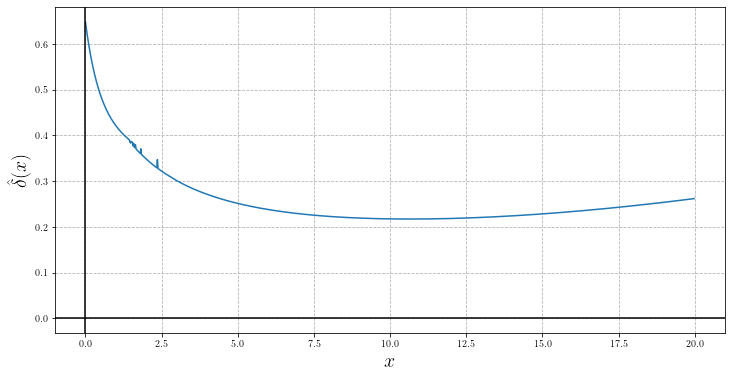

In [119]:
x = np.linspace(0,i*DELTA,i)
plt.figure(figsize=(12,6))
plt.plot(x,deltahat[0:i])
plt.xlabel('$x$', fontsize=20)
plt.ylabel(r'$\hat{\delta}(x)$', fontsize=20)
plt.axhline(y=0, color='k');plt.axvline(x=0, color='k')
plt.grid( color='0.7', linestyle='--')
plt.savefig("./plots/ExcessOfLoss/DELTAhat" +NAME, bbox_inches='tight')
plt.show()

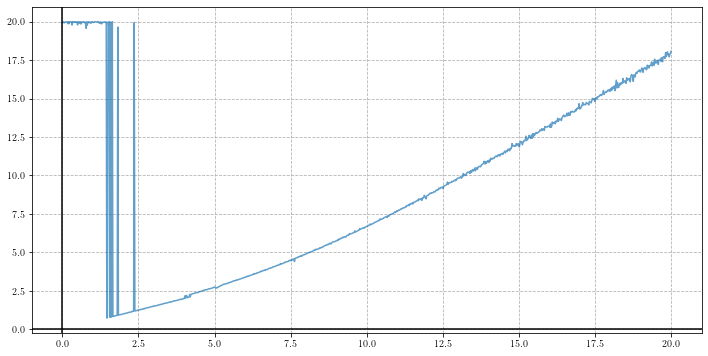

In [120]:
x = np.linspace(0,end,n)
plt.figure(figsize=(12,6))
#plt.plot(x, B2,label='$b_2(x)$',alpha=0.7, linestyle='dashdot')
plt.plot(x, B1,label='$b_1(x)$',alpha=0.7)
#plt.plot(x, B3,label='$b_3(x)$',alpha=0.7)
#plt.xlim(14.5,15)
#plt.ylim(199.1,200.1)
plt.axhline(y=0, color='k');plt.axvline(x=0, color='k')
plt.grid( color='0.7', linestyle='--')
plt.show()

In [121]:
IndMin = np.argmin(deltahat)

In [122]:
deltahat[IndMin]

0.2172371694891965

In [123]:
IndMin*DELTA

10.64

In [124]:
x = np.linspace(0,end,n+1)
v = delta
vhat = deltahat
V = v/vhat[IndMin]
Vp = vhat/vhat[IndMin]

V[IndMin+1:] = V[IndMin] + np.arange(IndMin+1, n+1)*DELTA - (IndMin)*DELTA
Vp[IndMin+1:] = 1.0

In [125]:
VoneXL=V-x

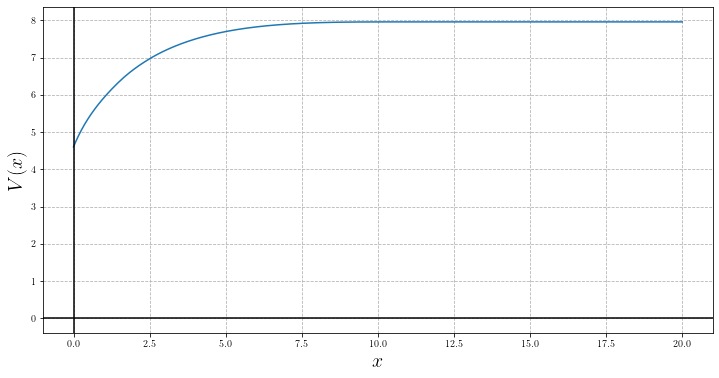

In [126]:
x = np.linspace(0,end,n+1)
plt.figure(figsize=(12,6))
plt.plot(x, VoneXL)
plt.xlabel('$x$', fontsize=20)
plt.ylabel(r'$V(x)$', fontsize=20)
#plt.xlim(0,17.5)
plt.axhline(y=0, color='k');plt.axvline(x=0, color='k')
plt.grid( color='0.7', linestyle='--')
plt.show()

In [127]:
import pandas as pd
IND = np.arange(0,n)
x = np.linspace(0,end,n+1)
DF = pd.DataFrame([x[IND],VoneXL[IND],B1[IND],B2[IND],B3[IND]],
                  index=['x','V_XL','XLXLXL_Line1','XLXLXL_Line2','XLXLXL_Line3']).T
DF.to_csv('oneXL_20_0.02_copy2.csv')